C:\Users\david\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


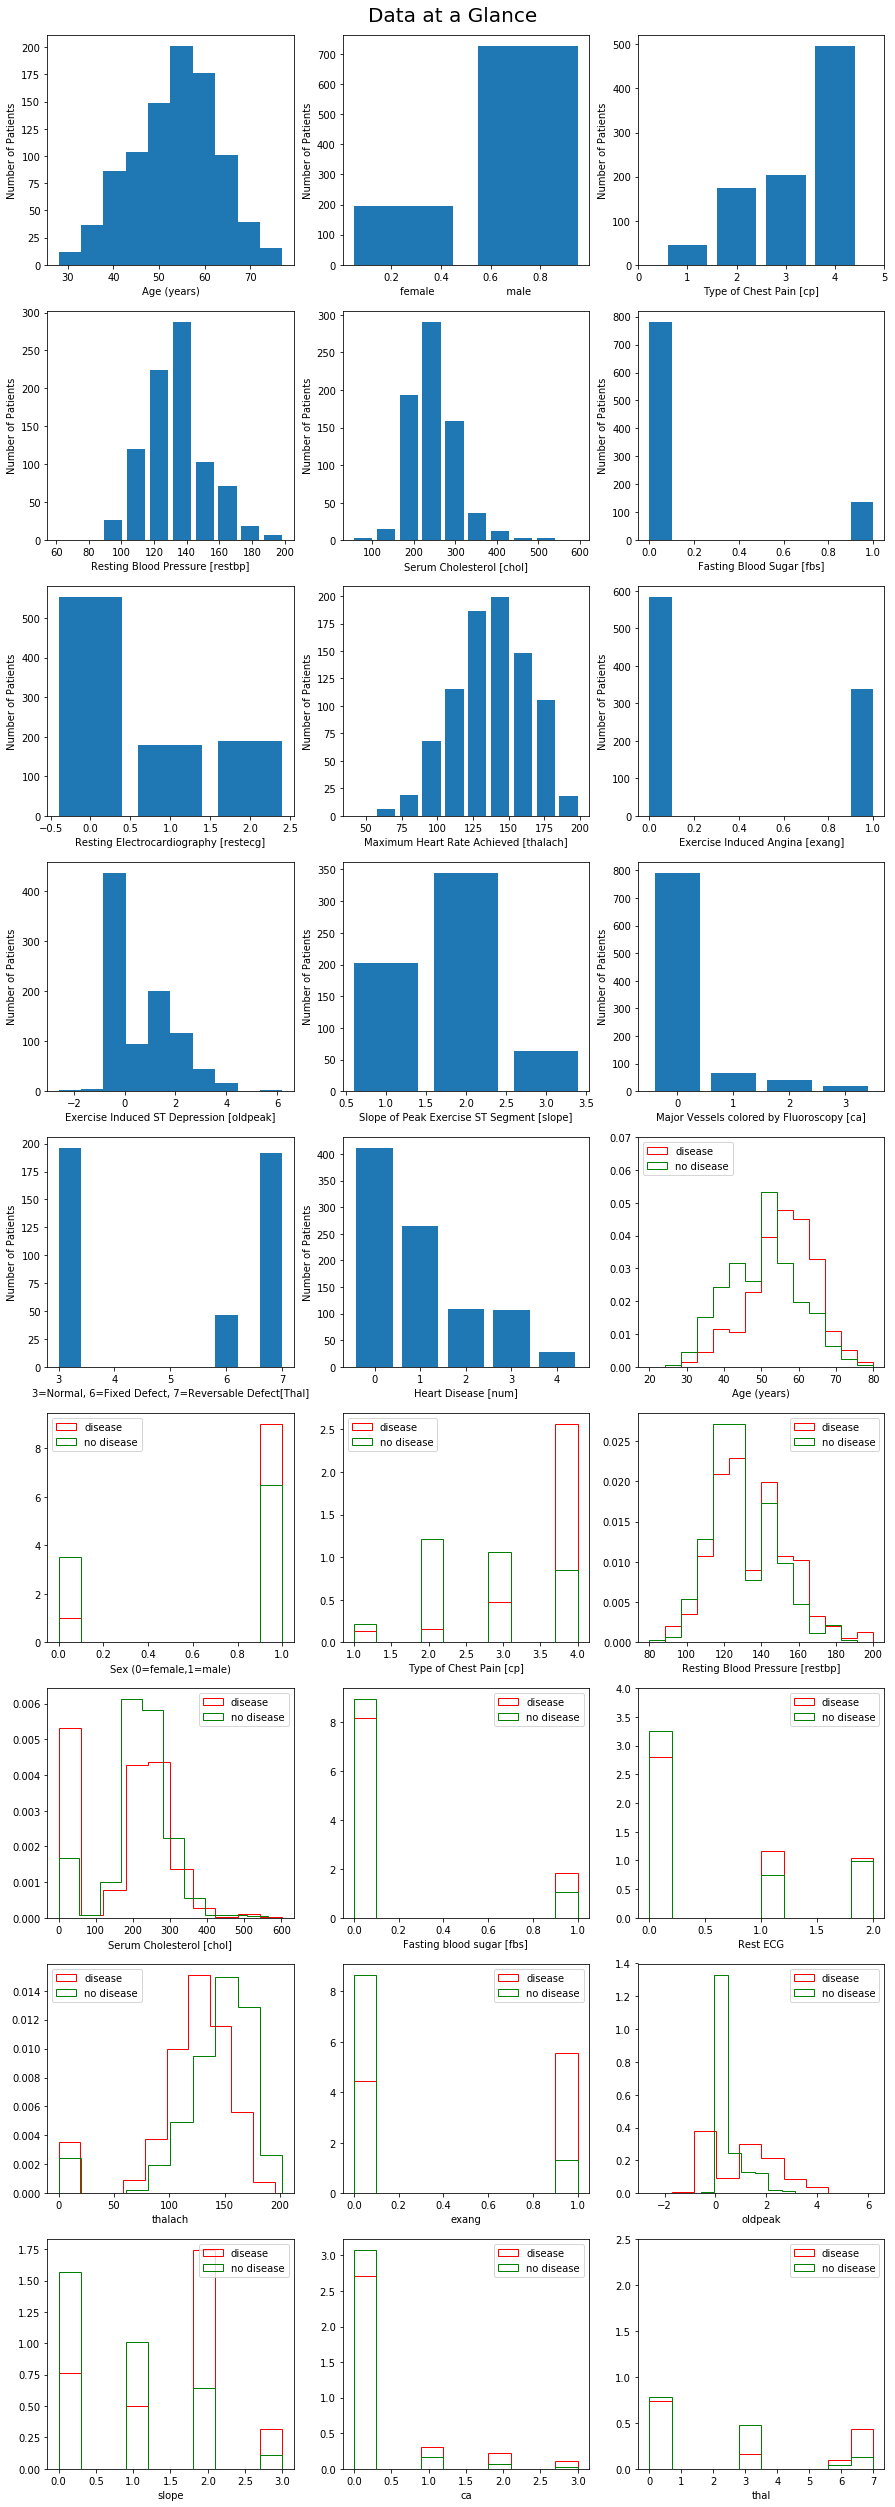

In [1]:
%matplotlib inline
import os
import random
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from pprint import pprint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


#get the current directory
path = os.getcwd()
# Read in Feature Names
fN = (path + './data/featureNames.txt')
#dSet = (path + './data/Processed_Data.csv')
dSet = (path + './data/completeDSet.csv')
f75out = (path + "./data/trainingSet.csv")
f25out = (path + "./data/testingSet.csv")
knnOut = (path + "./data/KNN_results.txt")


# Given two histograms x and y the following function
# calculates the intrinsic discrepancy between them
def intrinsic_discrepancy(x,y):
    assert len(x)==len(y)
    sumx = sum(xval for xval in x)
    sumy = sum(yval for yval in y)
    id1 = 0.0
    id2 = 0.0
    for (xval,yval) in zip(x,y):
        if (xval>0) and (yval>0):
            id1 += (float(xval)/sumx) * np.log((float(xval)/sumx)/(float(yval)/sumy))
            id2 += (float(yval)/sumy) * np.log((float(yval)/sumy)/(float(xval)/sumx))
    return min(id1,id2)

# Create Pandas dataframe.
#hn = pd.read_csv(fN, sep='\n', header=None)
#hddf = pd.read_csv(dSet, sep=',', names = headers.values.T.tolist()[0])
columns = ["age", "sex", "cp", "restbp", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
df0 = pd.read_table(dSet, sep=',', header=None, names=columns)
df0.fillna("0")
# Make some plots to check the data
fig, axes = plt.subplots( nrows=9, ncols=3, figsize=(15,40) )
plt.subplots_adjust( wspace=0.20, hspace=0.20, top=0.97 )
plt.suptitle("Data at a Glance", fontsize=20)
axes[0,0].hist(df0.age)
axes[0,0].set_xlabel("Age (years)")
axes[0,0].set_ylabel("Number of Patients")

axes[0,1].set_xlabel("female                       male",ha="center")
axes[0,1].hist(df0.sex, bins=2,range=(0,1), rwidth=0.80)
axes[0,1].set_ylabel("Number of Patients")

axes[0,2].hist(df0.cp,bins=4,range=(0.5,4.5),rwidth=0.8)
axes[0,2].set_xlim(0.0,5.0)
axes[0,2].set_xlabel("Type of Chest Pain [cp]")
axes[0,2].set_ylabel("Number of Patients")

axes[1,0].hist(df0.restbp, range=(60,200), rwidth=0.8)
axes[1,0].set_xlabel("Resting Blood Pressure [restbp]")
axes[1,0].set_ylabel("Number of Patients")

axes[1,1].hist(df0.chol, range=(50,600), rwidth=0.8)
axes[1,1].set_xlabel("Serum Cholesterol [chol]")
axes[1,1].set_ylabel("Number of Patients")

axes[1,2].hist(df0.fbs)
axes[1,2].set_xlabel("Fasting Blood Sugar [fbs]")
axes[1,2].set_ylabel("Number of Patients")

axes[2,0].hist(df0.restecg, bins=3, range=(-.5,2.5), rwidth=0.8)
axes[2,0].set_xlabel("Resting Electrocardiography [restecg]")
axes[2,0].set_ylabel("Number of Patients")

axes[2,1].hist(df0.thalach, range=(40,200), rwidth=0.8)
axes[2,1].set_xlabel("Maximum Heart Rate Achieved [thalach]")
axes[2,1].set_ylabel("Number of Patients")

axes[2,2].hist(df0.exang)
axes[2,2].set_xlabel("Exercise Induced Angina [exang]")
axes[2,2].set_ylabel("Number of Patients")

axes[3,0].hist(df0.oldpeak)
axes[3,0].set_xlabel("Exercise Induced ST Depression [oldpeak]")
axes[3,0].set_ylabel("Number of Patients")

axes[3,1].hist(df0.slope, bins=3, range=(.5,3.5), rwidth=0.8)
axes[3,1].set_xlabel("Slope of Peak Exercise ST Segment [slope]")
axes[3,1].set_ylabel("Number of Patients")

axes[3,2].hist(df0.ca,bins=4,range=(-0.5,3.5),rwidth=0.8)
axes[3,2].set_xlim(-0.7,3.7)
axes[3,2].set_xlabel("Major Vessels colored by Fluoroscopy [ca]")
axes[3,2].set_ylabel("Number of Patients")

axes[4,0].hist(df0.thal, range=(3,7),rwidth=1)
axes[4,0].set_xlabel("3=Normal, 6=Fixed Defect, 7=Reversable Defect[Thal]")
axes[4,0].set_ylabel("Number of Patients")

axes[4,1].hist(df0.num,bins=5,range=(-0.5,4.5),rwidth=0.8)
axes[4,1].set_xlim(-0.7,4.7)
axes[4,1].set_xlabel("Heart Disease [num]")
axes[4,1].set_ylabel("Number of Patients")

# feature distributions for disease and no-disease
bins = np.linspace(20, 80, 15)
axes[4,2].hist(df0[df0.num>0].age.tolist(),bins,color=["red"],histtype="step",label="disease",normed=True)
axes[4,2].hist(df0[df0.num==0].age,bins,color=["green"],histtype="step",label="no disease",normed=True)
axes[4,2].set_xlabel("Age (years)")
axes[4,2].set_ylim(0.0,0.070)
axes[4,2].legend(prop={'size': 10},loc="upper left")

axes[5,0].hist(df0[df0.num>0].sex.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[5,0].hist(df0[df0.num==0].sex,color=["green"],histtype="step",label="no disease",normed=True)
axes[5,0].set_xlabel("Sex (0=female,1=male)")
axes[5,0].legend(prop={'size': 10},loc="upper left")

axes[5,1].hist(df0[df0.num>0].cp.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[5,1].hist(df0[df0.num==0].cp,color=["green"],histtype="step",label="no disease",normed=True)
axes[5,1].set_xlabel("Type of Chest Pain [cp]")
axes[5,1].legend(prop={'size': 10},loc="upper left")

bins = np.linspace(80, 200, 15)
axes[5,2].hist(df0[df0.num>0].restbp.tolist(),bins,color=["red"],histtype="step",label="disease",normed=True)
axes[5,2].hist(df0[df0.num==0].restbp,bins,color=["green"],histtype="step",label="no disease",normed=True)
axes[5,2].set_xlabel("Resting Blood Pressure [restbp]")
axes[5,2].legend(prop={'size': 10},loc="upper right")

axes[6,0].hist(df0[df0.num>0].chol.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[6,0].hist(df0[df0.num==0].chol,color=["green"],histtype="step",label="no disease",normed=True)
axes[6,0].set_xlabel("Serum Cholesterol [chol]")
axes[6,0].legend(prop={'size': 10},loc="upper right")

axes[6,1].hist(df0[df0.num>0].fbs.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[6,1].hist(df0[df0.num==0].fbs,color=["green"],histtype="step",label="no disease",normed=True)
axes[6,1].set_xlabel("Fasting blood sugar [fbs]")
axes[6,1].legend(prop={'size': 10},loc="upper right")

axes[6,2].hist(df0[df0.num>0].restecg.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[6,2].hist(df0[df0.num==0].restecg,color=["green"],histtype="step",label="no disease",normed=True)
axes[6,2].set_xlabel("Rest ECG")
axes[6,2].set_ylim(0.0,4.0)
axes[6,2].legend(prop={'size': 10},loc="upper right")

axes[7,0].hist(df0[df0.num>0].thalach.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[7,0].hist(df0[df0.num==0].thalach,color=["green"],histtype="step",label="no disease",normed=True)
axes[7,0].set_xlabel("thalach")
axes[7,0].legend(prop={'size': 10},loc="upper left")

axes[7,1].hist(df0[df0.num>0].exang.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[7,1].hist(df0[df0.num==0].exang,color=["green"],histtype="step",label="no disease",normed=True)
axes[7,1].set_xlabel("exang")
axes[7,1].legend(prop={'size': 10},loc="upper right")

axes[7,2].hist(df0[df0.num>0].oldpeak.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[7,2].hist(df0[df0.num==0].oldpeak,color=["green"],histtype="step",label="no disease",normed=True)
axes[7,2].set_xlabel("oldpeak")
axes[7,2].legend(prop={'size': 10},loc="upper right")

axes[8,0].hist(df0[df0.num>0].slope.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[8,0].hist(df0[df0.num==0].slope,color=["green"],histtype="step",label="no disease",normed=True)
axes[8,0].set_xlabel("slope")
axes[8,0].legend(prop={'size': 10},loc="upper right")

axes[8,1].hist(df0[df0.num>0].ca.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[8,1].hist(df0[df0.num==0].ca,color=["green"],histtype="step",label="no disease",normed=True)
axes[8,1].set_xlabel("ca")
axes[8,1].legend(prop={'size': 10},loc="upper right")

axes[8,2].hist(df0[df0.num>0].thal.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[8,2].hist(df0[df0.num==0].thal,color=["green"],histtype="step",label="no disease",normed=True)
axes[8,2].set_xlabel("thal")
axes[8,2].set_ylim(0.0,2.5)
axes[8,2].legend(prop={'size': 10},loc="upper right")
plt.show()

In [2]:
# Intrinsic discrepancies in disease/no-disease feature distributions on the training dataset 
int_discr = {}
hist,bin_edges   = np.histogram(df0.age,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].age,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].age,bins=bin_edges,density=False)
int_discr["age"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].sex,bins=(-0.5,0.5,1.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].sex,bins=(-0.5,0.5,1.5),density=False)
int_discr["sex"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].cp,bins=(0.5,1.5,2.5,3.5,4.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].cp,bins=(0.5,1.5,2.5,3.5,4.5),density=False)
int_discr["cp"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.restbp,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].restbp,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].restbp,bins=bin_edges,density=False)
int_discr["restbp"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.chol,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].chol,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].chol,bins=bin_edges,density=False)
int_discr["chol"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].fbs,bins=(-0.5,0.5,1.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].fbs,bins=(-0.5,0.5,1.5),density=False)
int_discr["fbs"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].restecg,bins=(-0.5,0.5,1.5,2.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].restecg,bins=(-0.5,0.5,1.5,2.5),density=False)
int_discr["restecg"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.thalach,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].thalach,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].thalach,bins=bin_edges,density=False)
int_discr["thalach"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].exang,bins=(-0.5,0.5,1.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].exang,bins=(-0.5,0.5,1.5),density=False)
int_discr["exang"] = intrinsic_discrepancy(hist1,hist2)
hist,bin_edges   = np.histogram(df0.oldpeak,density=False)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].oldpeak,bins=bin_edges,density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].oldpeak,bins=bin_edges,density=False)
int_discr["oldpeak"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].slope,bins=(0.5,1.5,2.5,3.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].slope,bins=(0.5,1.5,2.5,3.5),density=False)
int_discr["slope"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].ca,bins=(-0.5,0.5,1.5,2.5,3.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].ca,bins=(-0.5,0.5,1.5,2.5,3.5),density=False)
int_discr["ca"] = intrinsic_discrepancy(hist1,hist2)
hist1,bin_edges1 = np.histogram(df0[df0.num>0].thal,bins=(2.5,3.5,6.5,7.5),density=False)
hist2,bin_edges2 = np.histogram(df0[df0.num==0].thal,bins=(2.5,3.5,6.5,7.5),density=False)
int_discr["thal"] = intrinsic_discrepancy(hist1,hist2)
id_list = Counter(int_discr).most_common()
for item in id_list:
    print ('Intrinsic discrepancies between disease and no-disease for %s is: %f' % (item[0],item[1],))

# Convert categorical variables with more than two values into dummy variables.
# Note that variable ca is discrete but not categorical, so we don't convert it.
df = df0.copy()
dummies = pd.get_dummies(df["cp"],prefix="cp")
df = df.join(dummies)
del df["cp"]
del df["cp_4"]
df = df.rename(columns = {"cp_1":"cp1","cp_2":"cp2","cp_3":"cp3"})

dummies = pd.get_dummies(df["restecg"],prefix="recg")
df = df.join(dummies)
del df["restecg"]
del df["recg_0"]
df = df.rename(columns = {"recg_1":"recg1","recg_2":"recg2"})

dummies = pd.get_dummies(df["slope"],prefix="slope")
df = df.join(dummies)
del df["slope_0"]
del df["slope_2"]
df = df.rename(columns = {"slope_1":"slope1","slope_3":"slope3"})

dummies = pd.get_dummies(df["thal"],prefix="thal")
df = df.join(dummies)
del df["thal_0"]
del df["thal_3"]
df = df.rename(columns = {"thal_6":"thal6","thal_7":"thal7"})

# Replace response variable values and rename
df["num"].replace(to_replace=[1,2,3,4],value=1,inplace=True)
df = df.rename(columns = {"num":"HD"})

# New list of column labels after the above operations
new_columns_1 = ["age", "sex", "restbp", "chol", "fbs", "thalach", 
                 "exang", "oldpeak", "ca", "HD", "cp1", "cp2",
                 "cp3", "recg1", "recg2", "slope1", "slope3",
                 "thal6", "thal7"]

print ('\nNumber of patients in dataframe: %i, with disease: %i, without disease: %i\n'% (len(df.index),len(df[df.HD==1].index),len(df[df.HD==0].index)))

# Standardize the dataframe
stdcols = ["age","restbp","chol","thalach","oldpeak"]
nrmcols = ["ca"]
stddf = df.copy()
stddf.fillna('0')
stddf[stdcols] = stddf[stdcols].apply(lambda x: (x-x.mean())/x.std())
stddf[nrmcols] = stddf[nrmcols].apply(lambda x: (x-x.mean())/(x.max()-x.min()))

new_columns_2 = new_columns_1[:9] + new_columns_1[10:]
new_columns_2.insert(0,new_columns_1[9])
stddf = stddf.reindex(columns=new_columns_2)

# Convert dataframe into lists for use by classifiers
yall = stddf["HD"]
Xall = stddf[new_columns_2[1:]].values

Intrinsic discrepancies between disease and no-disease for cp is: 0.627439
Intrinsic discrepancies between disease and no-disease for thal is: 0.554669
Intrinsic discrepancies between disease and no-disease for exang is: 0.384881
Intrinsic discrepancies between disease and no-disease for oldpeak is: 0.313605
Intrinsic discrepancies between disease and no-disease for slope is: 0.298476
Intrinsic discrepancies between disease and no-disease for thalach is: 0.289996
Intrinsic discrepancies between disease and no-disease for chol is: 0.178247
Intrinsic discrepancies between disease and no-disease for age is: 0.177981
Intrinsic discrepancies between disease and no-disease for sex is: 0.170816
Intrinsic discrepancies between disease and no-disease for ca is: 0.054324
Intrinsic discrepancies between disease and no-disease for restbp is: 0.041973
Intrinsic discrepancies between disease and no-disease for restecg is: 0.024604
Intrinsic discrepancies between disease and no-disease for fbs is: 0.

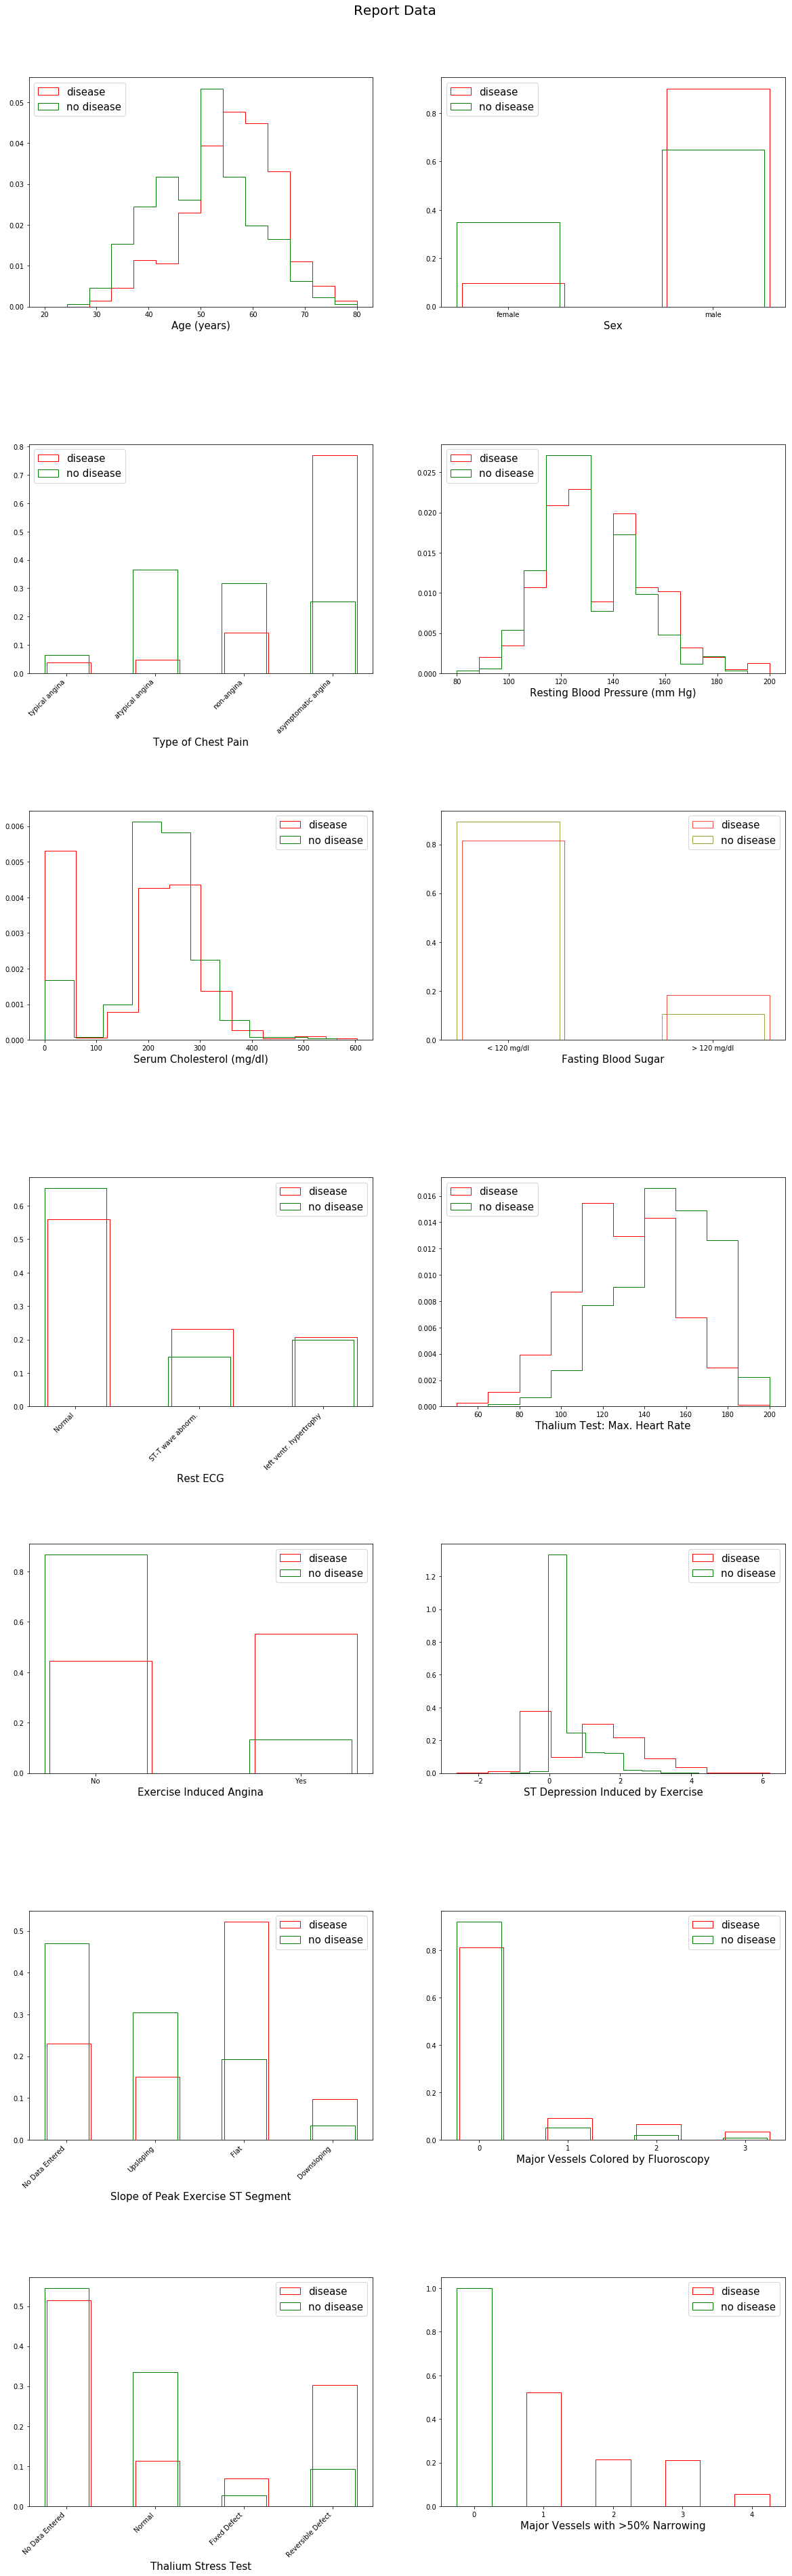

In [3]:
fig, axes = plt.subplots( nrows=7, ncols=2, figsize=(20,60) )
plt.subplots_adjust( wspace=0.20, hspace=0.60, top=0.955)
plt.suptitle("Report Data", fontsize=20)

bins = np.linspace(20, 80, 15)
axes[0,0].hist(df0[df0.num>0].age.tolist(),bins,color=["red"],histtype="step",label="disease",normed=True)
axes[0,0].hist(df0[df0.num==0].age,bins,color=["green"],histtype="step",label="no disease",normed=True)
axes[0,0].set_xlabel("Age (years)",fontsize=15)
axes[0,0].legend(prop={'size': 15},loc="upper left")

bins = np.arange(2)
width = 0.5
heights1 = df0[df0.num>0]["sex"].groupby(df0["sex"]).count()
heights2 = df0[df0.num==0]["sex"].groupby(df0["sex"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[0,1].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[0,1].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[0,1].set_xlabel("Sex",fontsize=15)
axes[0,1].set_xticks(bins)
axes[0,1].set_xticklabels(["female","male"],ha="center")
axes[0,1].legend(prop={'size': 15},loc="upper left")

bins = np.arange(4)
width = 0.5
heights1 = df0[df0.num>0]["cp"].groupby(df0["cp"]).count()
heights2 = df0[df0.num==0]["cp"].groupby(df0["cp"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[1,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[1,0].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[1,0].set_xlabel("Type of Chest Pain",fontsize=15)
axes[1,0].set_xticks(bins)
axes[1,0].set_xticklabels(["typical angina", "atypical angina", "non-angina", "asymptomatic angina"],ha="right",rotation=45.)
axes[1,0].legend(prop={'size': 15},loc="upper left")

bins = np.linspace(80, 200, 15)
axes[1,1].hist(df0[df0.num>0].restbp.tolist(),bins,color=["red"],histtype="step",label="disease",normed=True)
axes[1,1].hist(df0[df0.num==0].restbp,bins,color=["green"],histtype="step",label="no disease",normed=True)
axes[1,1].set_xlabel("Resting Blood Pressure (mm Hg)",fontsize=15)
axes[1,1].legend(prop={'size': 15},loc="upper left")

axes[2,0].hist(df0[df0.num>0].chol.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[2,0].hist(df0[df0.num==0].chol,color=["green"],histtype="step",label="no disease",normed=True)
axes[2,0].set_xlabel("Serum Cholesterol (mg/dl)",fontsize=15)
axes[2,0].legend(prop={'size': 15},loc="upper right")

bins = np.arange(2)
width = 0.5
heights1 = df0[df0.num>0]["fbs"].groupby(df0["fbs"]).count()
heights2 = df0[df0.num==0]["fbs"].groupby(df0["fbs"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[2,1].bar(bins+0.025,heights1,width,align="center",edgecolor=(0.917,0.083,0,0.75),color=["none"],label="disease")
axes[2,1].bar(bins,heights2,width,align="center",edgecolor=(0.467,0.533,0,0.75),color=["none"],label="no disease")
axes[2,1].set_xlabel("Fasting Blood Sugar",fontsize=15)
axes[2,1].set_xticks(bins)
axes[2,1].set_xticklabels(["< 120 mg/dl","> 120 mg/dl"],ha="center")
axes[2,1].legend(prop={'size': 15},loc="upper right")

bins = np.arange(3)
width = 0.5
heights1 = df0[df0.num>0]["restecg"].groupby(df0["restecg"]).count()
heights2 = df0[df0.num==0]["restecg"].groupby(df0["restecg"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[3,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[3,0].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[3,0].set_xlabel("Rest ECG",fontsize=15)
axes[3,0].set_xticks(bins)
axes[3,0].set_xticklabels(["Normal","ST-T wave abnorm.","left ventr. hypertrophy"],ha="right",rotation=45.)
axes[3,0].legend(prop={'size': 15},loc="upper right")

axes[3,1].hist(df0[df0.num>0].thalach.tolist(),color=["red"],histtype="step",label="disease",normed=True, range=(50,200))
axes[3,1].hist(df0[df0.num==0].thalach,color=["green"],histtype="step",label="no disease",normed=True, range=(50,200))
axes[3,1].set_xlabel("Thalium Test: Max. Heart Rate",fontsize=15)
axes[3,1].legend(prop={'size': 15},loc="upper left")

bins = np.arange(2)
width = 0.5
heights1 = df0[df0.num>0]["exang"].groupby(df0["exang"]).count()
heights2 = df0[df0.num==0]["exang"].groupby(df0["exang"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[4,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[4,0].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[4,0].set_xlabel("Exercise Induced Angina",fontsize=15)
axes[4,0].set_xticks(bins)
axes[4,0].set_xticklabels(["No","Yes"],ha="center")
axes[4,0].legend(prop={'size': 15},loc="upper right")

axes[4,1].hist(df0[df0.num>0].oldpeak.tolist(),color=["red"],histtype="step",label="disease",normed=True)
axes[4,1].hist(df0[df0.num==0].oldpeak,color=["green"],histtype="step",label="no disease",normed=True)
axes[4,1].set_xlabel("ST Depression Induced by Exercise", fontsize=15)
axes[4,1].legend(prop={'size': 15},loc="upper right")

bins = np.arange(4)
width = 0.5
heights1 = df0[df0.num>0]["slope"].groupby(df0["slope"]).count()
heights2 = df0[df0.num==0]["slope"].groupby(df0["slope"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[5,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[5,0].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[5,0].set_xlabel("Slope of Peak Exercise ST Segment",fontsize=15)
axes[5,0].set_xticks(bins)
axes[5,0].set_xticklabels(["No Data Entered","Upsloping","Flat","Downsloping"],ha="right",rotation=45.)
axes[5,0].legend(prop={'size': 15},loc="upper right")

bins = np.arange(4)
width = 0.5
heights1 = df0[df0.num>0]["ca"].groupby(df0["ca"]).count()
heights2 = df0[df0.num==0]["ca"].groupby(df0["ca"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[5,1].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[5,1].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[5,1].set_xlabel("Major Vessels Colored by Fluoroscopy",fontsize=15)
axes[5,1].set_xticks(bins)
axes[5,1].set_xticklabels(["0","1","2","3"],ha="center")
axes[5,1].legend(prop={'size': 15},loc="upper right")

bins = np.arange(4)
width = 0.5
heights1 = df0[df0.num>0]["thal"].groupby(df0["thal"]).count()
heights2 = df0[df0.num==0]["thal"].groupby(df0["thal"]).count()
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[6,0].bar(bins+0.025,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[6,0].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[6,0].set_xlabel("Thalium Stress Test",fontsize=15)
axes[6,0].set_xticks(bins)
axes[6,0].set_xticklabels(["No Data Entered","Normal","Fixed Defect","Reversible Defect"],ha="right",rotation=45.)
axes[6,0].legend(prop={'size': 15},loc="upper right")

bins = np.arange(5)
width = 0.5
heights1 = np.array([0]+df0[df0.num>0]["num"].groupby(df0["num"]).count().tolist())
heights2 = np.array(df0[df0.num==0]["num"].groupby(df0["num"]).count().tolist()+[0,0,0,0])
heights1 = heights1/sum(heights1)
heights2 = heights2/sum(heights2)
axes[6,1].bar(bins,heights1,width,align="center",edgecolor=["red"],color=["none"],label="disease")
axes[6,1].bar(bins,heights2,width,align="center",edgecolor=["green"],color=["none"],label="no disease")
axes[6,1].set_xlabel("Major Vessels with >50% Narrowing",fontsize=15)
axes[6,1].set_xticks(bins)
axes[6,1].set_xticklabels(["0","1","2","3","4"],ha="center")
axes[6,1].legend(prop={'size': 15},loc="upper right")


plt.show()


In [4]:
lasso = False

nfeatures = len(stddf.columns)
if lasso: # lasso regularization
    penalty = "l1"
    cval = 1.0
    alpha = [1.0]*nfeatures
else:  # no regularization
    penalty = "l1"
    cval = 1000.0
    alpha = 0.0

model = LogisticRegression(fit_intercept=True,penalty=penalty,dual=False,C=cval)
print(model)
lrfit = model.fit(Xall,yall)
print('\nLogisticRegression score on the training data set: %f\n' % lrfit.score(Xall,yall))
ypred = model.predict(Xall)
print ('\nClassification report on training data set:')
print(metrics.classification_report(yall,ypred))
print ('\nConfusion matrix:')
print(metrics.confusion_matrix(yall,ypred))
print ('\nLogisticRegression coefficients:')
coeff = model.coef_.tolist()[0]
for index in range(len(coeff)):
    print ('%s : %8.5f' % (new_columns_2[index+1].rjust(9),coeff[index]))
print ('Intercept : %f' %model.intercept_)

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression score on the training data set: 0.821739


Classification report on training data set:
             precision    recall  f1-score   support

          0       0.81      0.79      0.80       411
          1       0.83      0.85      0.84       509

avg / total       0.82      0.82      0.82       920


Confusion matrix:
[[323  88]
 [ 76 433]]

LogisticRegression coefficients:
      age :  0.16463
      sex :  1.13747
   restbp :  0.11378
     chol : -0.45074
      fbs :  0.42852
  thalach : -0.42947
    exang :  1.07589
  oldpeak :  0.55114
       ca :  2.11797
      cp1 : -1.19779
      cp2 : -2.09719
      cp3 : -1.49468
    recg1 :  0.15895
    recg2 : -0.15784
   slope1 : -0.60572
   slope3 : -0.4424

In [5]:
df1 = stddf.copy()
df1["intercept"] = 1.0

train_cols = df1[df1.columns[1:]]
response = df1[df1.columns[0]]
model = sm.Logit(response, train_cols, missing="raise")
 
# fit the model
print('\nNumber of features in model: %i' %nfeatures)
print('Lasso = %s' % lasso)
if lasso: print('alpha=%s' %alpha)
print(" ")

if lasso:
    result = model.fit_regularized(method=penalty, alpha=alpha, disp=1)
else:
    result = model.fit(method="newton", maxiter=100, disp=1)

print (result.summary())


Number of features in model: 19
Lasso = False
 
Optimization terminated successfully.
         Current function value: 0.398837
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     HD   No. Observations:                  920
Model:                          Logit   Df Residuals:                      901
Method:                           MLE   Df Model:                           18
Date:                Wed, 04 Apr 2018   Pseudo R-squ.:                  0.4198
Time:                        12:14:07   Log-Likelihood:                -366.93
converged:                       True   LL-Null:                       -632.47
                                        LLR p-value:                3.020e-101
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.1646      0.112      1.475      0.140     

In [6]:
def select_features(df0,**kwargs):
    if "verbose" in kwargs: 
        vb = kwargs["verbose"]
    else:
        vb = 0
    if "method" in kwargs:
        md = kwargs["method"]
    else:
        md = "newton"
    feature_names = list(df0.columns)  
    feature_names.append("intercept")  # Add an intercept feature.
    nfeatures = len(feature_names) - 1 # First feature = response variable, so doesn't count.
    saved_columns = list(range(1,nfeatures+1))
    dropped_columns = []
    while len(saved_columns)>1:
        df1 = df0.copy()
        df1["intercept"] = 1.0
        df1 = df1.drop(df1.columns[dropped_columns],axis=1)
        features = df1[df1.columns[1:]]
        response = df1[df1.columns[0]]
        model = sm.Logit(response, features, missing="raise")
        result = model.fit(method=md, maxiter=100, disp=0)
        if len(saved_columns)==nfeatures:
            if vb >= 1:
                print ('\nInitial -log(L)=%8.5f; fit method = %s\n' %(-result.llf,md))
        if all(np.abs(tval) >= 2.0 for tval in result.tvalues):
            if vb >= 1:
                print ('\nFinal selection includes %i features:\n' % len(saved_columns))
                print (result.summary())
            break
        else:
            llfmin = 999999.0
            colmin = -100
            for col in saved_columns:
                dropped_columns.append(col)
                df1 = df0.copy()
                df1["intercept"] = 1.0
                df1 = df1.drop(df1.columns[dropped_columns],axis=1)
                features = df1[df1.columns[1:]]
                response = df1[df1.columns[0]]
                model = sm.Logit(response, features, missing="raise")
                result = model.fit(method=md, maxiter=100, disp=0)
                if -result.llf < llfmin:
                    llfmin = -result.llf
                    colmin = col
                dropped_columns.remove(col)
            if vb >= 2:
                print ('Dropping %s, -log(L)=%8.5f...' % (feature_names[colmin].rjust(9),llfmin))
            saved_columns.remove(colmin)
            dropped_columns.append(colmin)
    else:
        if vb >= 1:
            print ('Final selection has no features left')
    return result,saved_columns

select_features(stddf,verbose=2,method="newton")


Initial -log(L)=366.93024; fit method = newton

Dropping     recg2, -log(L)=367.10827...
Dropping     recg1, -log(L)=367.39577...
Dropping    restbp, -log(L)=367.81215...
Dropping intercept, -log(L)=368.27934...
Dropping    slope3, -log(L)=369.05953...
Dropping       fbs, -log(L)=370.20610...
Dropping     thal6, -log(L)=371.87211...

Final selection includes 12 features:

                           Logit Regression Results                           
Dep. Variable:                     HD   No. Observations:                  920
Model:                          Logit   Df Residuals:                      908
Method:                           MLE   Df Model:                           11
Date:                Tue, 03 Apr 2018   Pseudo R-squ.:                  0.4120
Time:                        20:42:33   Log-Likelihood:                -371.87
converged:                       True   LL-Null:                       -632.47
                                        LLR p-value:                9.6

(<statsmodels.discrete.discrete_model.BinaryResultsWrapper at 0x18b36461940>,
 [1, 2, 4, 6, 7, 8, 9, 10, 11, 12, 15, 18])

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

LogisticRegression score on full data set: 0.816304


Classification report on full data set:
             precision    recall  f1-score   support

          0       0.81      0.77      0.79       411
          1       0.82      0.85      0.84       509

avg / total       0.82      0.82      0.82       920


Confusion matrix:
[[316  95]
 [ 74 435]]

Number of disease cases: 509, no-disease cases: 411


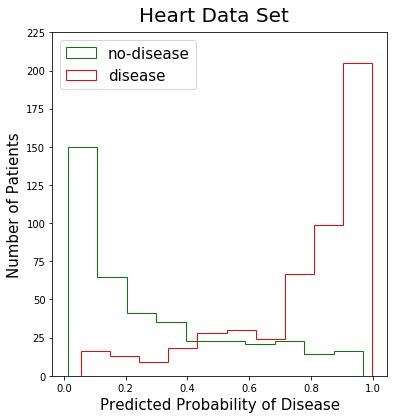

In [6]:
model = LogisticRegression(fit_intercept=False,penalty="l1",dual=False,C=1000.0)
comb = [0,1,3,5,6,7,8,9,10,11,14,17]
Xsel  = []
for patient in Xall:
    Xsel.append([patient[ind] for ind in comb])
print(model)
lrfit = model.fit(Xsel,yall)
print('\nLogisticRegression score on full data set: %f\n' % lrfit.score(Xsel,yall))
ypred = model.predict(Xsel)
print ('\nClassification report on full data set:')
print(metrics.classification_report(yall,ypred))
print ('\nConfusion matrix:')
print(metrics.confusion_matrix(yall,ypred))

# Separate disease from no-disease cases for a histogram of logistic regression probabilities:
Xsel0 = [patient for (patient,status) in zip(Xsel,yall) if status==0] # No-disease cases
Xsel1 = [patient for (patient,status) in zip(Xsel,yall) if status==1] # Disease cases
print('\nNumber of disease cases: %i, no-disease cases: %i' %(len(Xsel1),len(Xsel0)))
Xsel0_Prob = [p1 for (p0,p1) in model.predict_proba(Xsel0)] # Predicted prob. of heart disease for no-disease cases
Xsel1_Prob = [p1 for (p0,p1) in model.predict_proba(Xsel1)] # Predicted prob. of heart disease for disease cases

# Here is the plot:
fig, axes = plt.subplots( nrows=1, ncols=1, figsize=(6,6) )
plt.subplots_adjust( top=0.92 )
plt.suptitle("Heart Data Set", fontsize=20)
axes.hist(Xsel0_Prob,color=["green"],histtype="step",label="no-disease")
axes.hist(Xsel1_Prob,color=["red"],histtype="step",label="disease")
axes.set_xlabel("Predicted Probability of Disease",fontsize=15)
axes.set_ylabel("Number of Patients",fontsize=15)
axes.set_ylim( 0.0, 225.0 )
axes.legend(prop={'size': 15},loc="upper left")
plt.show()

In [7]:
best_score = []
best_std = []
best_comb = []
nfeatures = 18
iterable = range(nfeatures)
gnb = GaussianNB()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(gnb, Xsel, y=yall, cv=3 )
            score_mean  = np.mean(this_scores)
            score_std   = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std = []
                    best_comb = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print ('For comb=%s, Gaussian Naive Bayes Accuracy = %f +/- %f'% (best_comb[ind],best_score[ind],best_std[ind]))

For comb=(0, 1, 3, 4, 6, 7, 10, 11, 17), Gaussian Naive Bayes Accuracy = 0.799987 +/- 0.044751


In [8]:
model = GaussianNB()
comb = [0,1,3,4,6,7,10,11,17]
Xsel  = []
for patient in Xall:
    Xsel.append([patient[ind] for ind in comb])
print(model)
gnbfit = model.fit(Xsel,yall)
print('\nGaussianNB score on full data set: %f\n' % gnbfit.score(Xsel,yall))
ypred = model.predict(Xsel)
print ('\nClassification report on full data set:')
print(metrics.classification_report(yall,ypred))
print ('\nConfusion matrix:')
print(metrics.confusion_matrix(yall,ypred))

GaussianNB(priors=None)

GaussianNB score on full data set: 0.815217


Classification report on full data set:
             precision    recall  f1-score   support

          0       0.79      0.79      0.79       411
          1       0.83      0.83      0.83       509

avg / total       0.82      0.82      0.82       920


Confusion matrix:
[[326  85]
 [ 85 424]]


In [9]:
best_score = []
best_std = []
best_comb = []
nfeatures = 18
iterable = range(nfeatures)
model = RandomForestClassifier()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(model, Xsel, y=yall, cv=3 )
            score_mean = np.mean(this_scores)
            score_std = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std = []
                    best_comb = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print ('For comb=%s, Random Forest Classifier Accuracy = %f +/- %f' % (best_comb[ind],best_score[ind],best_std[ind]))

For comb=(1, 6, 10, 11, 17), Random Forest Classifier Accuracy = 0.788007 +/- 0.031634


In [34]:
model = RandomForestClassifier()

comb = [3,7,10,14,15]
Xsel  = []
for patient in Xall:
    Xsel.append([patient[ind] for ind in comb])
print(model)
rffit = model.fit(Xsel,yall)
print('\Random Forrest score on full data set: %f\n' % rffit.score(Xsel,yall))
ypred = model.predict(Xsel)
print ('\nClassification report on full data set:')
print(metrics.classification_report(yall,ypred))
print ('\nConfusion matrix:')
print(metrics.confusion_matrix(yall,ypred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
\Random Forrest score on full data set: 0.894565


Classification report on full data set:
             precision    recall  f1-score   support

          0       0.91      0.87      0.89       460
          1       0.88      0.92      0.90       460

avg / total       0.90      0.89      0.89       920


Confusion matrix:
[[401  59]
 [ 38 422]]


In [19]:
best_score = []
best_std = []
best_comb = []
nfeatures = 18
iterable = range(nfeatures)
model = SVC()
for s in range(len(iterable)+1):
    for comb in itertools.combinations(iterable, s):
        if len(comb) > 0:
            Xsel = []
            for patient in Xall:
                Xsel.append([patient[ind] for ind in comb])
            this_scores = cross_val_score(model, Xsel, y=yall, cv=3 )
            score_mean = np.mean(this_scores)
            score_std = np.std(this_scores)
            if len(best_score) > 0: 
                if score_mean > best_score[0]:
                    best_score = []
                    best_std = []
                    best_comb = []
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
                elif score_mean == best_score[0]:
                    best_score.append(score_mean)
                    best_std.append(score_std)
                    best_comb.append(comb)
            else:
                best_score.append(score_mean)
                best_std.append(score_std)
                best_comb.append(comb)
num_ties = len(best_score)
for ind in range(num_ties):
    print ('For comb=%s, Support Vector Classifier Accuracy = %f +/- %f' %(best_comb[ind],best_score[ind],best_std[ind]))

For comb=(3, 7, 14, 16), Support Vector Classifier Accuracy = 0.709702 +/- 0.026233


In [21]:
model = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
comb = [3,7,14,16]
Xsel  = []
for patient in Xall:
    Xsel.append([patient[ind] for ind in comb])
print(model)
svmfit = model.fit(Xsel,yall)
print('\nSupport Vector Machine score on full data set: %f\n' % svmfit.score(Xsel,yall))
ypred = model.predict(Xsel)
print ('\nClassification report on full data set:')
print(metrics.classification_report(yall,ypred))
print ('\nConfusion matrix:')
print(metrics.confusion_matrix(yall,ypred))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Support Vector Machine score on full data set: 0.716304


Classification report on full data set:
             precision    recall  f1-score   support

          0       0.72      0.70      0.71       460
          1       0.71      0.73      0.72       460

avg / total       0.72      0.72      0.72       920


Confusion matrix:
[[322 138]
 [123 337]]
